In [1]:
pip install node2vec



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch-geometric



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#modeling jo
import numpy as np
import csv
import pandas as pd
pd.set_option('display.max_columns', None)
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community as nx_community
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from node2vec import Node2Vec
from sklearn.model_selection import RandomizedSearchCV, learning_curve, cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, train_test_split

In [165]:
from sklearn.preprocessing import StandardScaler

# 2. Charger les données
test_set_final = pd.read_csv("../data/test_set_final.csv", sep=",")
train_set_final = pd.read_csv("../data/train_set_final.csv", sep=",")
node_info = pd.read_csv("../data/node_information.csv", header=None)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])


In [166]:

def salton_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / ((degree_u * degree_v) ** 0.5)

def preferential_attachement(G, edges):
    PA = {}
    
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, degree_u * degree_v
    

def sorenson_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, 2 * common_neighbors / (degree_u + degree_v)


def hub_promoted_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / min(degree_u, degree_v)

def hub_depressed_similarity(G, edges):
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        degree_u = G.degree(u)
        degree_v = G.degree(v)
        yield u, v, common_neighbors / max(degree_u, degree_v)

def adamic_adar_index(G, edges):
    for u, v in edges:
        score = 0
        for w in nx.common_neighbors(G, u, v):
            degree_w = G.degree(w)
            if degree_w > 1:
                score += 1 / np.log(degree_w)
        yield u, v, score

# Creer une fonction qui ajoute des features (degree, centrality, clustering) à un graphes et qui merge node_info avec le graphe
def add_node_attributes(df, node_info):
     # Créer un graphe à partir du df
     if 'label' in df.columns:
        G = nx.from_pandas_edgelist(df, 'source', 'target', 'label')
     else:
        G = nx.from_pandas_edgelist(df, 'source', 'target')

     # Calculer les caractéristiques
     df['degree_source'] = df['source'].apply(lambda x: G.degree(x))
     df['centrality_source'] = df['source'].apply(lambda x: nx.degree_centrality(G)[x])
     #df['clustering_source'] = df['source'].apply(lambda x: nx.clustering(G)[x])

     df['degree_target'] = df['target'].apply(lambda x: G.degree(x))
     df['centrality_target'] = df['target'].apply(lambda x: nx.degree_centrality(G)[x])
     #df['clustering_target'] = df['target'].apply(lambda x: nx.clustering(G)[x])

     # Détecter les communautés et créer une caractéristique de communauté
     communities = nx_community.greedy_modularity_communities(G)
     community_map = {}
     for i, community in enumerate(communities):
          for node in community:
               community_map[node] = i
     df['community_source'] = df['source'].apply(lambda x: community_map[x])
     df['community_target'] = df['target'].apply(lambda x: community_map[x])

     df['pa'] = [i[2] for i in preferential_attachement(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de Jaccard
     df['jaccard'] = [i[2] for i in nx.jaccard_coefficient(G, df[['source', 'target']].values)]

     # Calculer le coefficient de similarité de Salton
     df['salton'] = [i[2] for i in salton_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Sorenson
     df['sorenson'] = [i[2] for i in sorenson_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Hub Promoted
     df['hub_promoted'] = [i[2] for i in hub_promoted_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Hub Depressed
     df['hub_depressed'] = [i[2] for i in hub_depressed_similarity(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de Leicht-Holme-Newman
     df['leicht_holme_newman'] = [i[2] for i in nx.preferential_attachment(G, df[['source', 'target']].values)]

     # Calculer le coefficient de similarité de adamic_adar
     df['adamic_adar'] = [i[2] for i in adamic_adar_index(G, df[['source', 'target']].values.tolist())]

     # Calculer le coefficient de similarité de resource_allocation_index
     df['resource_allocation'] = [i[2] for i in nx.resource_allocation_index(G, df[['source', 'target']].values)]

     # Calculer les common neighbors
     df['common_neighbors'] = df.apply(lambda x: len(list(nx.common_neighbors(G, x['source'], x['target']))), axis=1)
    
     shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
     df['shortest_path_length'] = [shortest_paths.get((source, target), -1) for source, target in zip(df['source'], df['target'])]

    # Calculate eigenvector centrality
     eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
     df['eigenvector_centrality_source'] = df['source'].apply(lambda x: eigenvector_centrality.get(x, 0))
     df['eigenvector_centrality_target'] = df['target'].apply(lambda x: eigenvector_centrality.get(x, 0))

     
     # Fusionner node_info avec le df
     node_info.rename(columns={0: 'node_id'}, inplace=True)
     df = df.merge(node_info, left_on='source', right_on='node_id', how='left')
     # rename toutes les colonnes de node_info ajouter par "nom_col"+"source"
     df.rename(columns={col: str(col) + '_source' for col in node_info.columns[1:]}, inplace=True)
     df.drop('node_id', axis=1, inplace=True)


     df = df.merge(node_info, left_on='target', right_on='node_id', how='left')
     # rename toutes les colonnes de node_info ajouter par "nom_col"+"source"
     df.rename(columns={col: str(col) + '_target' for col in node_info.columns[1:]}, inplace=True)
     df.drop('node_id', axis=1, inplace=True)
     return df

# Ajouter les caractéristiques au train_set
train_set = add_node_attributes(train_set, node_info)
test_set = add_node_attributes(test_set, node_info)

train_set.head()


source  target  label  degree_source  centrality_source  degree_target  \
0     939    3809      1              4           0.001112            361   
1    2442    5784      1             11           0.003059              4   
2     179    3809      1              8           0.002225            361   
3     857    2280      1              9           0.002503             21   
4    1358    5722      1              3           0.000834             17   

   centrality_target  community_source  community_target    pa   jaccard  \
0           0.100389                 2                 0  1444  0.000000   
1           0.001112                 3                 3    44  0.071429   
2           0.100389                 0                 0  2888  0.005450   
3           0.005840                 0                 4   189  0.000000   
4           0.004727                 2                 2    51  0.000000   

     salton  sorenson  hub_promoted  hub_depressed  leicht_holme_newman  \
0  0.000000  0.000000          0.00       0.000000                 1444   
1  0.150756  0.133333          0.25       0.090909                   44   
2  0.037216  0.010840          0.25       0.005540                 2888   
3  0.000000  0.000000          0.00       0.000000                  189   
4  0.000000  0.000000          0.00       0.000000                   51   

   adamic_adar  resource_allocation  common_neighbors  shortest_path_length  \
0     0.000000             0.000000                 0                    -1   
1     0.513898             0.142857                 1                    -1   
2     0.857549             0.194444                 2                    -1   
3     0.000000             0.000000                 0                    -1   
4     0.000000             0.000000                 0                    -1   

   eigenvector_centrality_source  eigenvector_centrality_target  1_source  \
0                       0.036479                       0.693586       0.0   
1                       0.002788                       0.000319       0.0   
2                       0.040864                       0.693586       0.0   
3                       0.037566                       0.005744       0.0   
4                       0.000397                       0.001462       0.0   

   2_source  3_source  4_source  5_source  6_source  7_source  8_source  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   9_source  10_source  11_source  12_source  13_source  14_source  15_source  \
0       0.0        0.0        0.0        0.0        0.0        0.0        0.0   
1       0.0        0.0        0.0        0.0        0.0        0.0        0.0   
2       0.0        0.0        0.0        0.0        0.0        0.0        0.0   
3       0.0        0.0        0.0        0.0        0.0        0.0        0.0   
4       0.0        0.0        0.0        0.0        0.0        0.0        0.0   

   16_source  17_source  18_source  19_source  20_source  21_source  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   22_source  23_source  24_source  25_source  26_source  27_source  \
0        1.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0

In [167]:
X_train = train_set.drop('label', axis=1)
y_train = train_set['label']



In [168]:
x_train_val, x_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [169]:
train_graph = nx.Graph()

train_graph.add_nodes_from(map(str, x_train_val['source']))
train_graph.add_nodes_from(map(str, x_train_val['target']))

# Add edges based on y_train_val
for idx, row in x_train_val.iterrows():
    source = str(row['source'])
    target = str(row['target'])
    label = y_train_val.loc[idx]  # Get label based on index
    if label == 1:  # Only add edges for connected nodes
        train_graph.add_edge(source, target)

# Train node2vec model
node2vec = Node2Vec(train_graph, dimensions=64, walk_length=50, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)



Computing transition probabilities:   0%|          | 0/7003 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


In [170]:
unique_nodes = set(X_train['source']).union(set(X_train['target']))
node_embeddings_dict = {}

for idx, node_id in enumerate(unique_nodes):
    if str(node_id) in model.wv:
        node_embeddings_dict[node_id] = model.wv[str(node_id)]
    else:
        # Handle the case where the node is not present in the embeddings
        # For example, you can use zero vectors or some default embedding
        node_embeddings_dict[node_id] = np.zeros(model.vector_size)

# Now you can create feature vectors for each row in X_train
X_train_embed = []

# Iterate over each row in X_train
for idx, row in X_train.iterrows():
    source_node = row['source']
    target_node = row['target']
    
    # Retrieve embeddings for the source and target nodes from the dictionary
    source_embedding = node_embeddings_dict[source_node]
    target_embedding = node_embeddings_dict[target_node]
    
    # Concatenate source and target embeddings to create a feature vector
    feature_vector = np.concatenate((source_embedding, target_embedding))
    
    # Append the feature vector to the list of feature vectors
    X_train_embed.append(feature_vector)

# Convert the list of feature vectors to a numpy array
X_train_embed = np.array(X_train_embed)


In [171]:
x_train_val, x_val, y_train_val, y_val = train_test_split(X_train_embed, y_train, test_size=0.1, random_state=42)


In [172]:
# Train logistic regression classifier
clf = LogisticRegression()

clf.fit(x_train_val, y_train_val)
# Predict labels for the validation set
predictions = clf.predict(x_val)
predictions_train = clf.predict(x_train_val)


# Compute accuracy
accuracy = accuracy_score(y_val, predictions)
accuracy_train = accuracy_score(y_train_val, predictions_train)

print(f"Validation Accuracy: {accuracy}")
print(f"Training Accuracy: {accuracy_train}")

Validation Accuracy: 0.5352380952380953
Training Accuracy: 0.5754816853694685


In [173]:
rf = RandomForestClassifier(random_state= 42, criterion = "gini", max_depth= 30, n_estimators= 500)
rf.fit(x_train_val, y_train_val)
y_pred = rf.predict(x_val)
y_pred_train = rf.predict(x_train_val)

print(f"Training Accuracy Random Forest: {accuracy_score(y_train_val, y_pred_train)}")
print(f"Validation Accuracy Random Forest: {accuracy_score(y_val, y_pred)}")


#Training Accuracy Random Forest: 0.8153882801333968
#Validation Accuracy Random Forest: 0.7323809523809524, with everything + max depth 30,est 500

Training Accuracy Random Forest: 1.0
Validation Accuracy Random Forest: 0.6885714285714286


Training Accuracy Gradient Boosting: 0.7306
Validation Accuracy Gradient Boosting: 0.7271


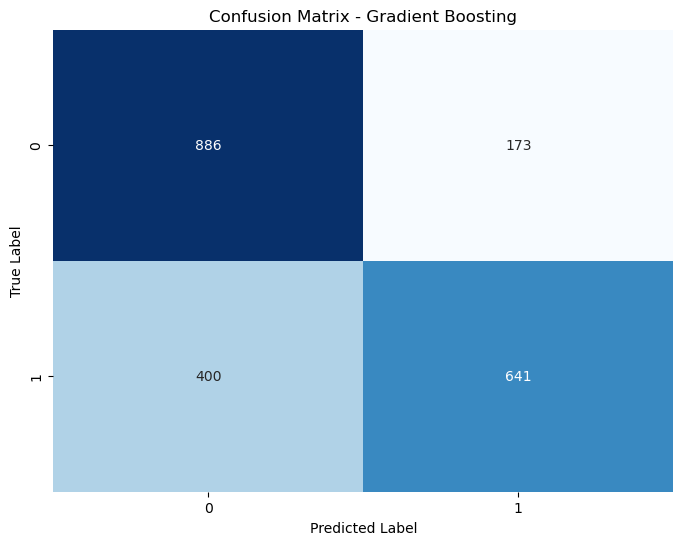

In [118]:
gradient_boosting = GradientBoostingClassifier(random_state=42, learning_rate= 0.05,n_estimators = 300)
gradient_boosting.fit(x_train_val, y_train_val)

# Predict labels on validation set
y_pred = gradient_boosting.predict(x_val)
y_pred_train = gradient_boosting.predict(x_train_val)

# Calculate and print training and validation accuracies
train_accuracy = accuracy_score(y_train_val, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Training Accuracy Gradient Boosting: {train_accuracy:.4f}")
print(f"Validation Accuracy Gradient Boosting: {val_accuracy:.4f}")

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

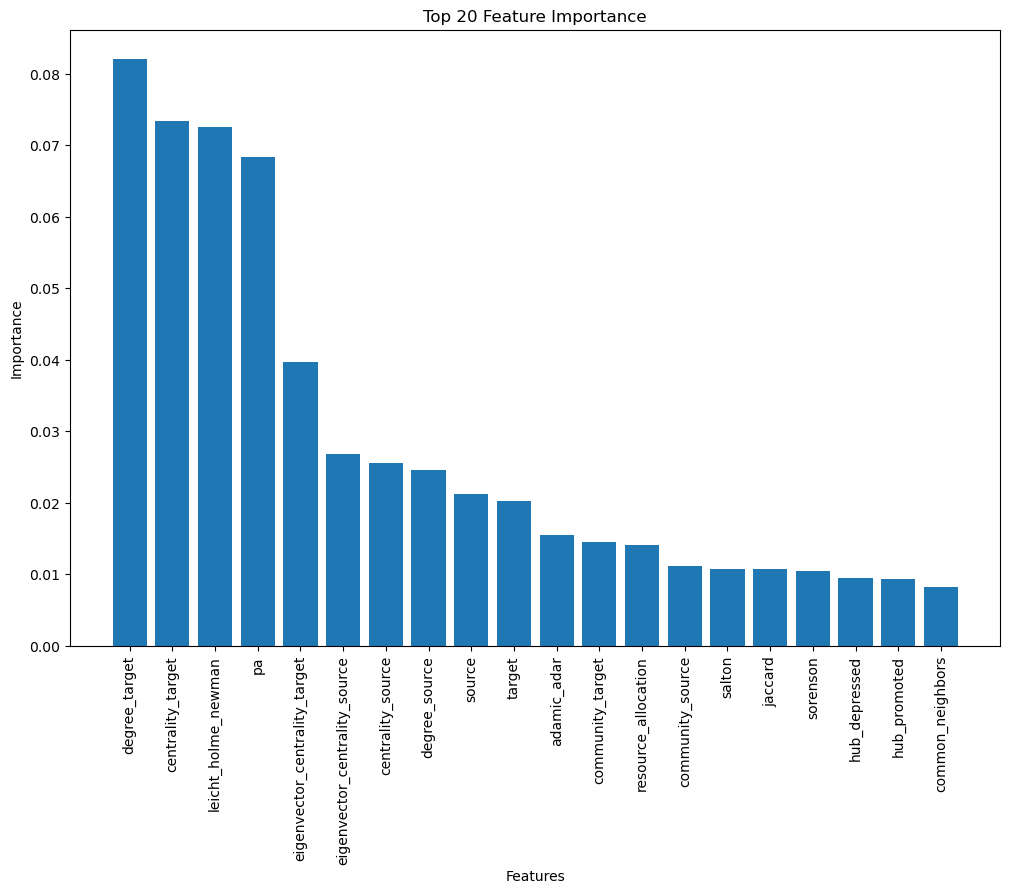

In [33]:
top_features = sorted_importances[:20]
features, importances = zip(*top_features)
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_features)), importances, tick_label=features)
plt.title('Top 20 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

In [ ]:
param_grid = {'n_estimators':np.arange(100,500,50),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [5, 7, 9, 12, 16],
              'max_samples': [0.3, 0.5, 0.8]}

X = train_set.drop('label', axis=1)
y = train_set['label']

rf = RandomForestClassifier(random_state= 42, criterion = "log_loss")

search = RandomizedSearchCV(rf, param_grid, scoring = 'accuracy', n_iter= 30,cv = 4, refit = True)
result = search.fit(X, y)

best_params = result.best_params_
best_score = result.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

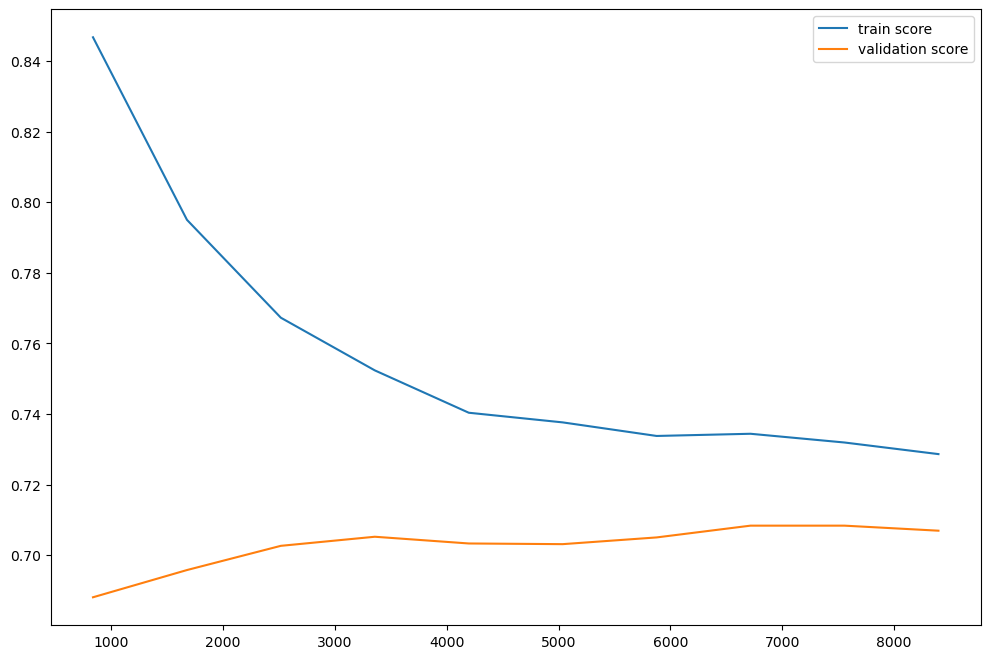

In [30]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

def evaluation(model):

    N, train_score, val_score = learning_curve(model, x_train, y_train,
                                              cv=kfold, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))


    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

evaluation(model)

SUBMISSIONS

In [97]:
test_predictions = rf.predict(test_set)
predictions_df = pd.DataFrame({'ID': test_set.index, 'Predicted': test_predictions})

predictions_df.to_csv('test_predictions.csv', index=False)
